<a href="https://colab.research.google.com/github/vroomgit/FraudDetectionFNN/blob/main/Fraud_Detection_Feedforward_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Feedforward Neural Network to detect fraudulent transactions in a simulated financial payments dataset

Link to dataset: https://www.kaggle.com/datasets/ealaxi/paysim1

## Environment prep and data unzipping (This section needed for Google Colab)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


## Loading and Preparing Data

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
from collections import Counter
import time
from time import sleep
!pip install pycm
import pycm
import prettytable
import sys
!{sys.executable}  -m pip -q -q install matplotlib;
!{sys.executable}  -m pip -q -q install seaborn;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.4/599.4 kB 15.2 MB/s eta 0:00:00


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Finance Dataset Kaggle/FFDS.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# For the fraud cases, are all nameOrig (origin ID) different? If yes, then this column can be dropped.
len(pd.unique(df.nameOrig[df.isFraud==1])) == len(df[df.isFraud==1])


True

In [7]:
# For the fraud cases, are all nameDest (destination ID) different? If yes, then this column can be dropped.
len(pd.unique(df.nameDest[df.isFraud==1]))

8169

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
# Percentage of labels = 1
(len(df)-len(df[df['isFraud']==1]))/len(df)

0.9987091795518198

In [10]:
# dropping column 'isFlaggedFraud' and nameOrig
df.drop(columns=['isFlaggedFraud'],inplace=True)
df.drop(columns=['nameOrig'],inplace=True)

In [11]:
# Number of nulls in dataset
for col in df.columns:
    print(col, df[col].isnull().sum())

step 0
type 0
amount 0
oldbalanceOrg 0
newbalanceOrig 0
nameDest 0
oldbalanceDest 0
newbalanceDest 0
isFraud 0


## In order to be fed into a neural network, the four 'object' type columns will be converted to embeddings. Choosing columns that will be encoded and calculating embedding sizes.



In [12]:
# Changing datatypes of 'object' types to 'category'

df["step"] = df["step"].astype("category")
df["type"] = df["type"].astype("category")
#df["nameOrig"] = df["nameOrig"].astype("category")
df["nameDest"] = df["nameDest"].astype("category")

In [13]:
# Defining labels
Y = df['isFraud']
df.drop(columns=['isFraud'],inplace=True)
print(len(df),len(Y))

6362620 6362620


In [14]:
# calculating number of categories in 'category' type columns.
embCol_dict = {}
for n,c in df.items():
  if str(df.dtypes[c.name]) == "category":
    if len(c.cat.categories) > 2:
      embCol_dict[c.name] = len(c.cat.categories)
embCol_dict

{'step': 743, 'type': 5, 'nameDest': 2722362}

Reference https://jovian.ai/aakanksha-ns/shelter-outcome

Below code calculates the size of embeddings based on number of categories in each column. The output size is min(50,(category size+1)/2). In case of step, nameOrig and nameDest, embeddings help in reducing categories to embeddings of length 50

In [15]:
# computing embedding sizes
embedding_sizes = [(n_categories, min(16, (n_categories+1)//2)) for _,n_categories in embCol_dict.items()]
embedding_sizes

[(743, 16), (5, 3), (2722362, 16)]

In [16]:
embCol_list = embCol_dict.keys()
len(embCol_list)

3

Encoding text categories in 'category' columns to integer codes using Sklearn's LabelEncoder

In [17]:
for col in df.columns:
  if (df.dtypes[col]) == "category":
    df[col] = LabelEncoder().fit_transform(df[col])

Portioning 70% data for training and 15% each for validation and testing.

In [18]:
np.random.seed(13)
X_train, X_val_test, y_train, y_val_test = train_test_split(df, Y, test_size=0.30)
X_train.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
3992863,297,3,10065.90,0.0,0.00,1427538,0.00,0.00
5609048,393,3,35667.84,69610.0,33942.16,1614022,0.00,0.00
6043451,489,0,408532.84,16636.0,425168.84,534679,809226.78,400693.94
1219187,132,1,455613.55,257470.0,0.00,423423,94728.63,550342.17
5325276,373,0,267214.37,21180.0,288394.37,401669,0.00,0.00


In [19]:
np.random.seed(13)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

In [20]:
# reset indexes to avoid errors in dataloader class
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)



In [21]:
print(len(X_train),len(y_train),len(X_val),len(y_val),len(X_test),len(y_test))

4453834 4453834 954393 954393 954393 954393


Data after encoding 'category' columns.

In [22]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0,3,9839.64,170136.0,160296.36,1662094,0.0,0.0
1,0,3,1864.28,21249.0,19384.72,1733924,0.0,0.0
2,0,4,181.00,181.0,0.00,439685,0.0,0.0
3,0,1,181.00,181.0,0.00,391696,21182.0,0.0
4,0,3,11668.14,41554.0,29885.86,828919,0.0,0.0


Defining the Dataset class.

In [23]:
class FraudData(Dataset):
    def __init__(self, df, y, embCol_list):

        self.X1 = df.loc[:,embCol_list].copy().values.astype(np.int64)
        self.X2 = df.drop(columns = embCol_list).copy().values.astype(np.float32)
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

Creating Dataset objects for Train/Validation/Test data

In [24]:
train_data = FraudData(X_train, y_train, embCol_list)
valid_data = FraudData(X_val, y_val, embCol_list)
test_data = FraudData(X_test, y_test, embCol_list)

In [ ]:
print(len(train_data),len(valid_data),len(test_data))

4453834 954393 954393


Defining Hyperparameters and Dataloader objects

In [ ]:
# Hyperparameters and creating train and validation loader variables

batch_size = 4096
lr = 0.0001
w_decay = 0.00001



trainloader = DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


validloader = DataLoader(valid_data, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

## Building Feedforward Neural Network.



In [ ]:
class FraudNet(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings)
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 256)
        self.lin2 = nn.Linear(256, 512)
        self.lin25 = nn.Linear(512, 256)
        self.lin3 = nn.Linear(256, 2)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(512)
        self.embedding_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)


    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.embedding_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = F.relu(self.lin25(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = self.lin3(x)
        return x

n_cont variable contains number of non-encoded columns

In [ ]:
n_cont = len(df.columns) - len(embCol_list)

In [ ]:
net = FraudNet(embedding_sizes, n_cont).to(device=device)
print(net)

FraudNet(
  (embeddings): ModuleList(
    (0): Embedding(743, 16)
    (1): Embedding(5, 3)
    (2): Embedding(2722362, 16)
  )
  (lin1): Linear(in_features=40, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=512, bias=True)
  (lin25): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)


In [ ]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

from prettytable import PrettyTable
def paramCount(model):
    t = PrettyTable(["Modules", "Parameters"])
    total_parameters = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
          continue
        params = parameter.numel()
        t.add_row([name, params])
        total_parameters+=params
    print(t)
    print(f"Total Trainable Params: {total_parameters}")
    return total_parameters

paramCount(net)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| embeddings.0.weight |   11888    |
| embeddings.1.weight |     15     |
| embeddings.2.weight |  43557792  |
|     lin1.weight     |   10240    |
|      lin1.bias      |    256     |
|     lin2.weight     |   131072   |
|      lin2.bias      |    512     |
|     lin25.weight    |   131072   |
|      lin25.bias     |    256     |
|     lin3.weight     |    512     |
|      lin3.bias      |     2      |
|      bn1.weight     |     5      |
|       bn1.bias      |     5      |
|      bn2.weight     |    256     |
|       bn2.bias      |    256     |
|      bn3.weight     |    512     |
|       bn3.bias      |    512     |
+---------------------+------------+
Total Trainable Params: 43845163


43845163

In [ ]:
criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(params = net.parameters(), lr=lr, weight_decay= w_decay)


In [ ]:
root_path = '/content/drive/My Drive/Projects/Finance Dataset Kaggle/'

## Training and Inference



In [ ]:
num_epochs = 24


tlossList = []
vlossList = []

np.random.seed(13)
valAccMax = 0
for epoch in range(0,num_epochs):  # loop over the dataset multiple times
    t=time.time()
    #sleep(0.5)
    #print("Epoch: ",epoch+1)
    trAcc = []
    valAcc = []
    train_batch_acc=0
    valid_batch_acc=0
    batch_loss=0
    valid_loss=0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        x1 = data[0].to(device=device)
        x2 = data[1].to(device=device)
        labels = data[2].type(torch.LongTensor).to(device=device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(x1, x2)

        loss = criterion(outputs, labels)
        batch_loss+=loss
        loss.backward()
        optimizer.step()

        # Batch Training Accuracy
        batchPred = torch.argmax(outputs, dim=1)
        batchAcc = np.mean(np.array((batchPred==labels).cpu()))
        trAcc.append(batchAcc)

    train_batch_acc = np.mean(trAcc)
        # Validation Accuracy
        #for id, d in enumerate(testloader):

    for i, (x1, x2, y) in enumerate(validloader):
        #print(x1,x2,y)
        #print(i)
        net.eval()
        inpx1 = x1.to(device=device)
        inpx2 = x2.to(device=device)
        lab = y.type(torch.LongTensor).to(device=device)


        np_lab = 0
        with torch.no_grad():
          out = net(inpx1,inpx2)
          vloss = criterion(out, lab)
          valid_loss+=vloss
          np_lab = np.array(lab.cpu())

        valPred = torch.argmax(out, dim=1)
        vAcc = np.mean(np.array((valPred==lab).cpu()))
        valAcc.append(vAcc)

    valid_batch_acc = np.mean(valAcc)
    if valid_batch_acc > valAccMax and epoch > 5:
      valAccMax = valid_batch_acc
      if valid_batch_acc > 0.9996:
        p = root_path + "modelAutoSave_" + "_" + str(round(valAccMax*100000,0)) + "_" +\
        str(epoch) + "_" + str(batch_size) + "_" + str(lr) + "_" + str(w_decay) + "_" + ".pth"
        torch.save(net.state_dict(), p)


    tlossList.append(batch_loss.item()/len(train_data))
    vlossList.append(valid_loss.item()/len(valid_data))


    # print statistics
    print("Epoch",epoch+1," | T Loss:", round(batch_loss.item()/len(train_data)*1e07,3),\
          " | V Loss:", round(valid_loss.item()/len(valid_data)*1e07,3),\
          " | T Accuracy:", round(train_batch_acc,6), " | V Accuracy:", round(valid_batch_acc,6),\
          " | Max Val Acc:", round(valAccMax,6), " | Epoch Time", round((time.time()-t)/60,2), "min")


print('Finished Training')

Epoch 1  | T Loss: 662.722  | V Loss: 86.123  | T Accuracy: 0.901306  | V Accuracy: 0.998711  | Max Val Acc: 0  | Epoch Time 1.59 min
Epoch 2  | T Loss: 28.575  | V Loss: 21.338  | T Accuracy: 0.998778  | V Accuracy: 0.998825  | Max Val Acc: 0  | Epoch Time 1.55 min
Epoch 3  | T Loss: 18.295  | V Loss: 14.4  | T Accuracy: 0.998895  | V Accuracy: 0.998994  | Max Val Acc: 0  | Epoch Time 1.54 min
Epoch 4  | T Loss: 12.624  | V Loss: 10.989  | T Accuracy: 0.999086  | V Accuracy: 0.999177  | Max Val Acc: 0  | Epoch Time 1.59 min
Epoch 5  | T Loss: 10.724  | V Loss: 9.878  | T Accuracy: 0.99918  | V Accuracy: 0.999227  | Max Val Acc: 0  | Epoch Time 1.59 min
Epoch 6  | T Loss: 9.604  | V Loss: 8.877  | T Accuracy: 0.999236  | V Accuracy: 0.999295  | Max Val Acc: 0  | Epoch Time 1.53 min
Epoch 7  | T Loss: 8.805  | V Loss: 8.631  | T Accuracy: 0.999295  | V Accuracy: 0.999292  | Max Val Acc: 0.999292  | Epoch Time 1.48 min
Epoch 8  | T Loss: 8.13  | V Loss: 7.702  | T Accuracy: 0.999349  | V

In [ ]:
# Save model
model_scripted = torch.jit.script(net)
model_scripted.save(root_path+'model_scripted_44M.pt')

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
#model = FraudNet(embedding_sizes, n_cont).to(device=device)
#model.load_state_dict(torch.load(root_path+'modelAutoSave__99965.0_22_4096_0.0001_1e-05_.pth'))
#model = torch.load(root_path+'modelAutoSave__99965.0_22_4096_0.0001_1e-05_.pth')
#model.eval()

#model = torch.jit.load(root_path+'model_scripted_50.pt')
#model.eval()

FraudNet(
  (embeddings): ModuleList(
    (0): Embedding(743, 16)
    (1): Embedding(5, 3)
    (2): Embedding(2722362, 16)
  )
  (lin1): Linear(in_features=40, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=512, bias=True)
  (lin25): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
  (bn1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_drop): Dropout(p=0.6, inplace=False)
  (drops): Dropout(p=0.3, inplace=False)
)

In [ ]:
# Loading testloader in variables for use in inference in training loop in next cell
testloader = DataLoader(test_data, batch_size=len(test_data),
                                         shuffle=False, num_workers=0)

for i, (x1, x2, y) in enumerate(testloader):
  inpx1_t = x1.to(device=device)
  inpx2_t = x2.to(device=device)
  lab_t = y.type(torch.CharTensor).to(device=device)

Checking accuracy on Testing Set

In [ ]:
# Evaluation for test data
model=net
model.eval()
with torch.no_grad():
  out = model(inpx1_t,inpx2_t)

a = torch.argmax(out, dim=1)
b = np.mean(np.array((a==lab_t).cpu()))
print("Test Accuracy: ",b,"Correctly Classified Datapoints: ",len(test_data)*b,\
      "Incorrectly Classified Datapoints: ",len(test_data)-len(test_data)*b )

Test Accuracy:  0.9996416570532265 Correctly Classified Datapoints:  954051.0 Incorrectly Classified Datapoints:  342.0


## Generating Confusion Matrix

In [ ]:
test_labels = np.array(lab_t.cpu())
test_predictions = np.array(a.cpu())

In [ ]:
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

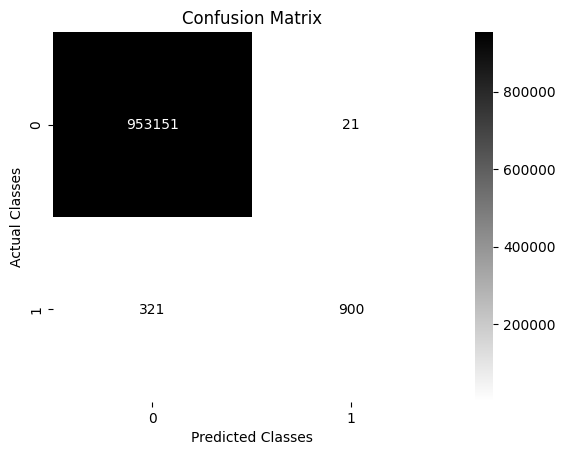

In [ ]:
# Confusion Matrix
cm=pycm.ConfusionMatrix(test_labels, test_predictions)
cm.plot(plot_lib="seaborn", number_label=True)


The above confusion matrix suggests the following:
1. Out of 1221 fraud cases in test set, 900 were correctly classified as Fraud (True Negative) and 321 were classified as regular transactions (False Positives). Thus, the model is 73.71% accurate in finding fraud.
2. The number of False Negatives is low (21) which means only a few regular transactions are falsely flagged as fraud.
3. By tuning the number of false positive and false negative cases, a financial organization can determine how much fraud they will allow in order to not bother customers with regular transactions with False Negative flags. In other words, the increase in fraud detection capabilites should not come at the expense of more false negatives.


#Comparison with XGBoost